# Review Classification using PyTorch

This notebook implements:
1. **Product Category Classification** - Multiclass classification for 10 product categories
2. **Fake Review Detection** - Binary classification to identify fake vs genuine reviews
3. **Word Cloud Generation** - Visualization of influential words in fake reviews


In [82]:
import pandas as pd
import numpy as np
import spacy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Load Data

In [71]:

df = pd.read_csv("fake_reviews_dataset.csv")

df.columns = [c.lower() for c in df.columns]

df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


# Tokenization (spaCy) 

In [72]:
nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])
def spacy_tokenizer(text):
    return [t.lemma_.lower() for t in nlp(str(text)) if not t.is_stop and t.is_alpha]

# TF-IDF Vectorization

In [73]:
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, max_features=5000)
X = vectorizer.fit_transform(df['text_']).toarray()

c:\Users\dmist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Encoding labels

In [89]:
cat_enc = LabelEncoder()
y_cat = cat_enc.fit_transform(df['category'])

bin_enc = LabelEncoder()
y_bin = bin_enc.fit_transform(df['label'])  # fake=1, genuine=0

# PyTorch Model

In [90]:
class FFNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, out_dim)
        )
    def forward(self, x): return self.net(x)

# Split train/test

In [91]:
def train_eval(X, y, out_dim):
    # 70% train, 30% temp
    Xtr, Xtmp, ytr, ytmp = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )

    # 15% val, 15% test (split temp 50/50)
    Xval, Xte, yval, yte = train_test_split(
        Xtmp, ytmp, test_size=0.50, random_state=42, stratify=ytmp
    )

    tr = DataLoader(
        TensorDataset(torch.FloatTensor(Xtr), torch.LongTensor(ytr)),
        batch_size=64, shuffle=True
    )
    val = DataLoader(
        TensorDataset(torch.FloatTensor(Xval), torch.LongTensor(yval)),
        batch_size=256
    )
    te = DataLoader(
        TensorDataset(torch.FloatTensor(Xte), torch.LongTensor(yte)),
        batch_size=256
    )

    return tr, val, te


# Training a model

In [92]:
def train_model(model, train_loader, val_loader,
                criterion, optimizer, device,
                epochs, patience):

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # ---- Train ----
        model.train()
        correct, total, train_loss = 0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(correct / total)

        # ---- Validation ----
        model.eval()
        correct, total, val_loss = 0, 0, 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)

                val_loss += loss.item()
                preds = outputs.argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)

        # ---- Early stopping ----
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return train_losses, val_losses, train_accs, val_accs


# Task 1:

In [115]:
train_loader_cat, val_loader_cat, test_loader_cat = train_eval(X, y_cat, len(cat_enc.classes_))

# Model, loss, optimizer
category_model = FFNN(X.shape[1], len(cat_enc.classes_)).to(device)
criterion_cat = nn.CrossEntropyLoss()
optimizer_cat = torch.optim.Adam(category_model.parameters(), lr=1e-3)

# Train
train_losses_cat, val_losses_cat, train_accs_cat, val_accs_cat = train_model(
    category_model,
    train_loader_cat,
    val_loader_cat,
    criterion_cat,
    optimizer_cat,
    device,
    epochs=40,
    patience=10
)


# Task 1 Evaluation


                              precision    recall  f1-score   support

                     Books_5       0.67      0.71      0.69       656
Clothing_Shoes_and_Jewelry_5       0.76      0.79      0.77       577
               Electronics_5       0.79      0.75      0.77       598
          Home_and_Kitchen_5       0.70      0.64      0.67       609
              Kindle_Store_5       0.75      0.71      0.73       709
             Movies_and_TV_5       0.87      0.85      0.86       538
              Pet_Supplies_5       0.84      0.85      0.84       638
       Sports_and_Outdoors_5       0.57      0.59      0.58       592
Tools_and_Home_Improvement_5       0.63      0.67      0.65       579
            Toys_and_Games_5       0.76      0.76      0.76       569

                    accuracy                           0.73      6065
                   macro avg       0.73      0.73      0.73      6065
                weighted avg       0.73      0.73      0.73      6065



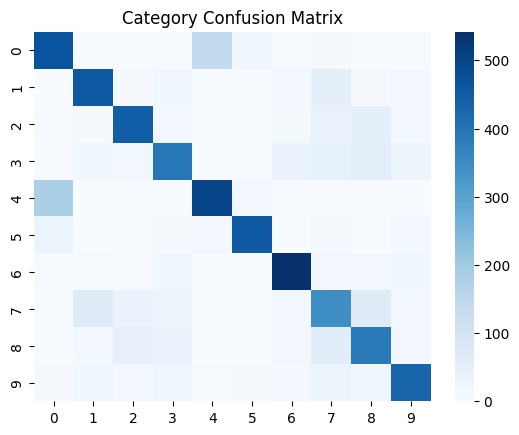

In [116]:
category_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader_cat:
        xb = xb.to(device)
        outputs = category_model(xb)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

print(classification_report(y_true, y_pred, target_names=cat_enc.classes_))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="Blues")
plt.title("Category Confusion Matrix")
plt.show()


# Task 2

In [123]:
train_loader_fake, val_loader_fake, test_loader_fake = train_eval(X, y_bin, 2)

fake_model = FFNN(X.shape[1], 2).to(device)
criterion_fake = nn.CrossEntropyLoss()
optimizer_fake = torch.optim.Adam(fake_model.parameters(), lr=1e-3)

train_model(
    fake_model,
    train_loader_fake,
    val_loader_fake,
    criterion_fake,
    optimizer_fake,
    device,
    epochs=10,
    patience=5
)

([0.4079112126649637,
  0.2908649842504992,
  0.26631262765579244,
  0.2468760769570385,
  0.22351141322748924,
  0.1913544729553819],
 [0.33398464942971867,
  0.34233594685792923,
  0.3487861330310504,
  0.3589833155274391,
  0.3675587686399619,
  0.3786018428703149],
 [0.8132994134690128,
  0.8732245071019716,
  0.8862271217581796,
  0.8950250865663204,
  0.9053423786304855,
  0.9202176524627235],
 [0.8527617477328937,
  0.8497938994229184,
  0.8464962901896125,
  0.8481450948062654,
  0.851277823577906,
  0.8474855729596042])

# Task 2 Evaluation Overall


=== Fake Review Detection: Overall ===
              precision    recall  f1-score   support

          CG       0.85      0.86      0.85      3033
          OR       0.86      0.84      0.85      3032

    accuracy                           0.85      6065
   macro avg       0.85      0.85      0.85      6065
weighted avg       0.85      0.85      0.85      6065



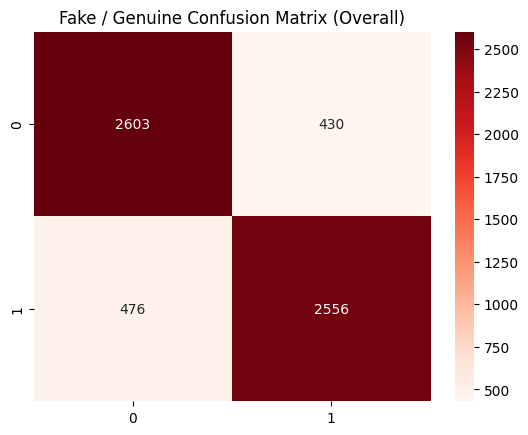

In [124]:
fake_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader_fake:
        xb = xb.to(device)
        outputs = fake_model(xb)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

print("\n=== Fake Review Detection: Overall ===")
print(classification_report(y_true, y_pred, target_names=bin_enc.classes_))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.title("Fake / Genuine Confusion Matrix (Overall)")
plt.show()


# Task 3: Word Cloud

## Distribution

In [107]:
# Identify fake label safely (OR / CG etc.)
print(bin_enc.classes_)

fake_label = 1   # assume encoded fake class = 1

fake_mask = (y_bin == fake_label)
genuine_mask = (y_bin != fake_label)

print(f"Fake reviews count: {fake_mask.sum()}")
print(f"Genuine reviews count: {genuine_mask.sum()}")


['CG' 'OR']
Fake reviews count: 20216
Genuine reviews count: 20216


# Category Wise Distribution

In [108]:
print("\nCategory-wise distribution:")

for category in df["category"].unique():
    subset = df[df["category"] == category]
    
    fake_count = (bin_enc.transform(subset["label"]) == fake_label).sum()
    genuine_count = len(subset) - fake_count
    
    print(f"Category: {category}")
    print(f"  Fake reviews:     {fake_count}")
    print(f"  Genuine reviews:  {genuine_count}\n")



Category-wise distribution:
Category: Home_and_Kitchen_5
  Fake reviews:     2028
  Genuine reviews:  2028

Category: Sports_and_Outdoors_5
  Fake reviews:     1973
  Genuine reviews:  1973

Category: Electronics_5
  Fake reviews:     1994
  Genuine reviews:  1994

Category: Movies_and_TV_5
  Fake reviews:     1794
  Genuine reviews:  1794

Category: Tools_and_Home_Improvement_5
  Fake reviews:     1929
  Genuine reviews:  1929

Category: Pet_Supplies_5
  Fake reviews:     2127
  Genuine reviews:  2127

Category: Kindle_Store_5
  Fake reviews:     2365
  Genuine reviews:  2365

Category: Books_5
  Fake reviews:     2185
  Genuine reviews:  2185

Category: Toys_and_Games_5
  Fake reviews:     1897
  Genuine reviews:  1897

Category: Clothing_Shoes_and_Jewelry_5
  Fake reviews:     1924
  Genuine reviews:  1924



In [109]:
# Separate fake and genuine reviews (SAFE)
fake_mask = (y_bin == 1)
genuine_mask = (y_bin == 0)

fake_tfidf = X[fake_mask]
genuine_tfidf = X[genuine_mask]

# Average TF-IDF scores
fake_avg = fake_tfidf.mean(axis=0)
genuine_avg = genuine_tfidf.mean(axis=0)

# Difference: words more associated with fake reviews
diff = fake_avg - genuine_avg

feature_names = vectorizer.get_feature_names_out()

fake_word_importance = {
    feature_names[i]: diff[i]
    for i in range(len(diff)) if diff[i] > 0
}



In [110]:
# Top words
top_fake_words = sorted(
    fake_word_importance.items(),
    key=lambda x: x[1],
    reverse=True
)[:20]

print("\nTop words associated with fake reviews:")
for word, score in top_fake_words:
    print(f"{word}: {score:.4f}")




Top words associated with fake reviews:
get: 0.0065
end: 0.0054
well: 0.0052
need: 0.0049
come: 0.0049
make: 0.0047
help: 0.0040
far: 0.0039
know: 0.0039
run: 0.0036
day: 0.0035
leave: 0.0035
take: 0.0034
water: 0.0034
actually: 0.0034
life: 0.0033
easily: 0.0033
will: 0.0031
fall: 0.0031
new: 0.0031


# Word Cloud

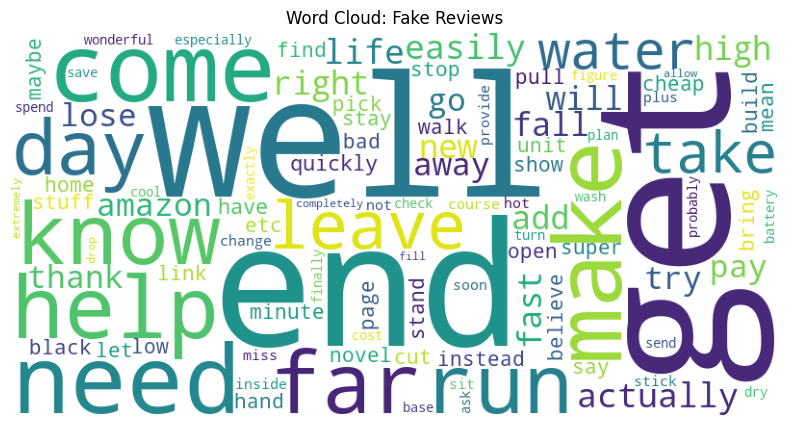

In [ ]:
wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate_from_frequencies(fake_word_importance)

plt.figure(figsize=(10, 5))
plt.imshow(wc)
plt.axis("off")
plt.title("Word Cloud: Fake Reviews")
plt.show()
